### Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats

import tensorflow as tf
from keras import Sequential, regularizers
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras_tuner import HyperModel, Hyperband

print("TensorFlow version: ", tf.__version__)
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.19.0
Number of GPUs available:  1


In [3]:
!nvidia-smi
# !kill -9 <PID>

Thu Apr 10 13:42:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40                     Off |   00000000:17:00.0 Off |                    0 |
| N/A   27C    P8             35W /  300W |       4MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Data Preprocessing

In [4]:
wind_cols = ['uSq','Z2','Z4']
scaled_wind_cols = ['scaled_' + col for col in wind_cols]

# Load datasets
df1 = pd.read_csv('Data_2004_2013.csv')

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)

# Train-Test split
# df_train: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2008-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# df_test: [2007-11-01 00:00:00 ~ 2008-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
df_train = df1[(df1.index < split1) | (df1.index > split2)]
df_test = df1[(df1.index > split1) & (df1.index < split2)]

# Data normalization
scaled_wave = MinMaxScaler()
scaled_wave = scaled_wave.fit(df_train[['H']])

### Data Preparation: Train-Test-Validation Split

In [5]:
time_step = 6
features = ['scaled_H'] + scaled_wind_cols

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step+1), 1:]) # (Past + Current) hours wind features
        y.append(data[i+time_step, 0])        # Current hour wave height
    return np.array(X), np.array(y)

# Training set: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2009-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# Validation set: [2008-11-01 00:00:00 ~ 2009-10-31 23:00:00]
split3 = pd.to_datetime('2009-10-31 23:59:00')
df_train1 = df_train[df_train.index < split1]
df_train2 = df_train[df_train.index > split3]
df_val = df_train[(df_train.index > split2) & (df_train.index < split3)]

X_train1, y_train1 = create_sequences(df_train1[features].values, time_step)
X_train2, y_train2 = create_sequences(df_train2[features].values, time_step)
X_train, y_train = np.concatenate((X_train1, X_train2), axis=0), np.concatenate((y_train1, y_train2), axis=0)
X_val, y_val = create_sequences(df_val[features].values, time_step)
X_test, y_test = create_sequences(df_test[features].values, time_step)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(61332, 7, 3)
(8754, 7, 3)
(8778, 7, 3)


### Model Selection and Implementation

In [6]:
alpha = 0.001
y_rescaled = scaled_wave.inverse_transform(y_train.reshape(-1, 1))
weights = alpha * np.exp(y_rescaled.flatten())

print(max(y_rescaled))
print(max(weights))

[10.170604]
26.123850805673012


I0000 00:00:1744306955.770877 3719330 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43500 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:17:00.0, compute capability: 8.9
I0000 00:00:1744306958.931294 3719384 cuda_dnn.cc:529] Loaded cuDNN version 90300


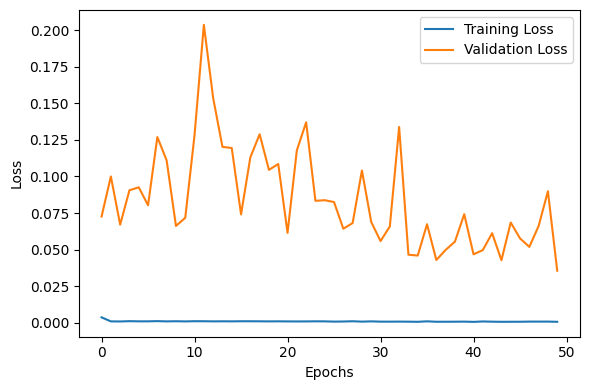

In [7]:
epochs = 50
batch_size = 64
model_file = 'model_reg4.keras'

# Model architecture
def create_model(X_train):
    model = Sequential([
        # Input layer with shape: (samples, time_steps, features)
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        
        # LSTM layers
        LSTM(64, activation='tanh', kernel_regularizer=regularizers.l2(0.01), dropout=0.2, return_sequences=False),
        
        # Output layer
        Dense(1),
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])
    
    return model

# Train and save the model (architecture + weights)
model = create_model(X_train)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, sample_weight=weights, validation_data=(X_val, y_val), verbose=0)
model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation

In [8]:
# Load the saved model
model = load_model(model_file)

# Training error
y_pred1 = model.predict(X_train, verbose=0)
y_pred1_raw = scaled_wave.inverse_transform(y_pred1)
y_true1 = pd.concat([df_train1['H'][time_step:], df_train2['H'][time_step:]], axis=0)
print(f'Training RMSE: {np.sqrt(mean_squared_error(y_true1, y_pred1_raw)):.3f}')

# Validation error
y_pred2 = model.predict(X_val, verbose=0)
y_pred2_raw = scaled_wave.inverse_transform(y_pred2)
y_true2 = df_val['H'][time_step:]
print(f'Validation RMSE: {np.sqrt(mean_squared_error(y_true2, y_pred2_raw)):.3f}')

# Test error
y_pred3 = model.predict(X_test, verbose=0)
y_pred3_raw = scaled_wave.inverse_transform(y_pred3)
y_true3 = df_test['H'][time_step:]
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_true3, y_pred3_raw)):.3f}')

Training RMSE: 2.004
Validation RMSE: 1.917
Test RMSE: 1.995


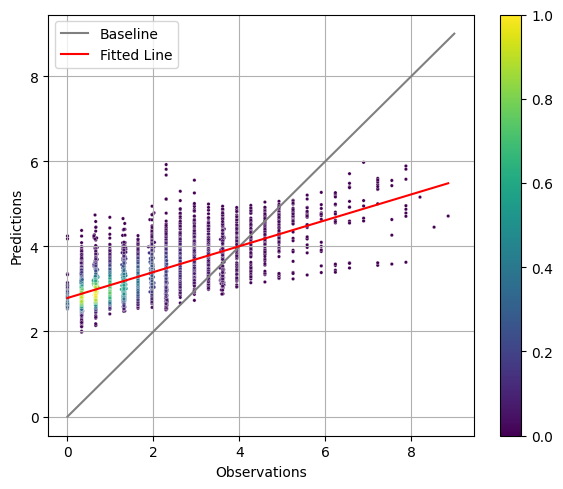

In [9]:
def pred_vs_obs(y_true, y_pred):
    y_pred = y_pred.flatten()
    fig, ax = plt.subplots(figsize=(6, 5))
    
    ax.plot([0, 9], [0, 9], color='grey', label='Baseline')
    ax.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true,y_pred,1))(np.unique(y_true)), color='r', label='Fitted Line')
    ax.set(xlabel='Observations', ylabel='Predictions')
    ax.legend()
    ax.grid()
    
    kernel = stats.gaussian_kde(np.vstack([y_true, y_pred]))(np.vstack([y_true, y_pred]))
    sns.scatterplot(x=y_true, y=y_pred, c=kernel, s=6, cmap='viridis', ax=ax)
    fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax)
    
    plt.tight_layout()
    plt.show()

pred_vs_obs(y_true3, y_pred3_raw)

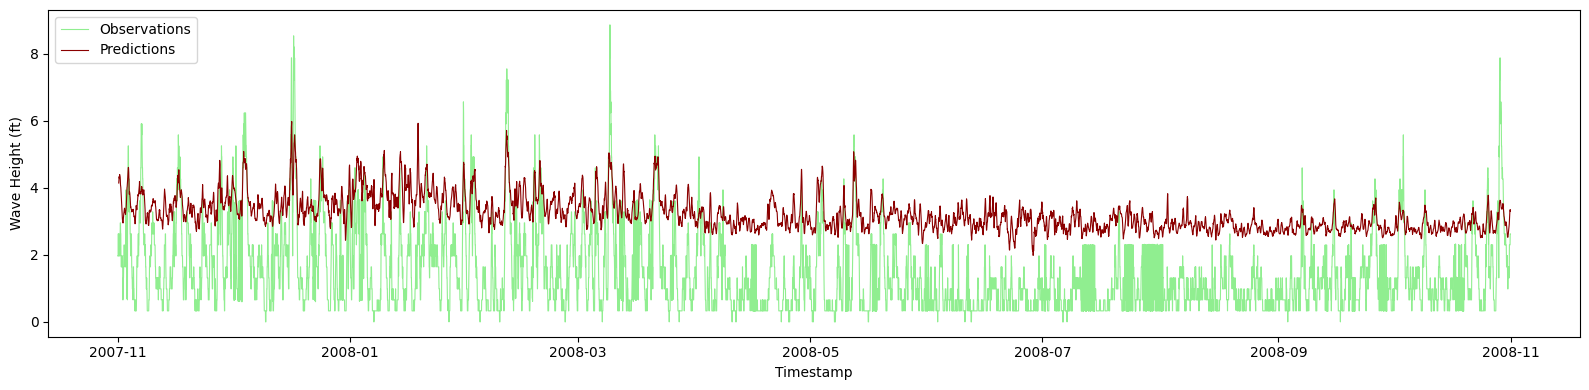

In [10]:
plt.figure(figsize=(16, 4))
plt.plot(df_test.index, df_test['H'], linewidth=0.8, color='lightgreen', label='Observations')
plt.plot(df_test.index[time_step:], y_pred3_raw, linewidth=0.8, color='darkred', label='Predictions')

plt.xlabel('Timestamp')
plt.ylabel('Wave Height (ft)')
plt.legend()

plt.tight_layout()
plt.show()

### Model Output

In [11]:
# Create sequences for the full dataset
X, _ = create_sequences(df1[features].values, time_step)

# Add predicted wave heights
df1['H_pred4'] = 0.0
df1.loc[df1.index[time_step:], 'H_pred4'] = model.predict(X, verbose=0).flatten()
df1.to_csv('Data_2004_2013.csv')

df1.head(10)

,Unnamed: 0,H,uSq,Z2,Z4,scaled_H,scaled_uSq,scaled_Z2,scaled_Z4,H_pred0,H_pred1,H_pred2,H_pred3,H_pred4
TimeStamp_1,,,,,,,,,,,,,,
2004-11-01 00:00:00,0,3.249133,19.225945,556.247086,465615.964363,0.319463,0.042443,0.101141,0.021635,0.000000,0.000000,0.000000,0.000000,0.000000
2004-11-01 01:00:00,1,3.249133,47.299731,872.475497,296853.635864,0.319463,0.111609,0.181946,0.012009,0.000000,0.000000,0.000000,0.000000,0.000000
2004-11-01 02:00:00,2,1.960359,43.096993,832.812792,310991.288972,0.192748,0.101255,0.171811,0.012816,0.000000,0.000000,0.000000,0.000000,0.000000
2004-11-01 03:00:00,3,2.001249,28.241040,674.161969,384177.000917,0.196768,0.064654,0.131272,0.016990,0.000000,0.000000,0.000000,0.000000,0.000000
2004-11-01 04:00:00,4,3.254957,35.278017,753.487381,343731.733585,0.320036,0.081991,0.151541,0.014683,0.000000,0.000000,0.000000,0.000000,0.000000
2004-11-01 05:00:00,5,3.298333,33.337921,732.475598,353592.016416,0.324301,0.077211,0.146172,0.015245,0.000000,0.000000,0.000000,0.000000,0.000000
2004-11-01 06:00:00,6,0.298153,67.513173,1042.361020,248471.996288,0.029315,0.161410,0.225356,0.009250,0.101553,0.277819,0.478686,0.147803,0.320912
2004-11-01 07:00:00,7,0.329992,43.711596,838.730115,308797.214744,0.032446,0.102769,0.173323,0.012690,0.103416,0.279069,0.480156,0.155682,0.331597
2004-11-01 08:00:00,8,0.307853,55.203975,942.560154,274780.895794,0.030269,0.131084,0.199855,0.010750,0.103958,0.279557,0.481290,0.155249,0.332195
